In [66]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import requests, io # internet and input tools  
import numpy as np
import os  

In [44]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

Below this reads in the Chinese tariff lists complied by Chad Bown [https://piie.com/blogs/trade-investment-policy-watch/trump-trade-war-china-date-guide](https://piie.com/blogs/trade-investment-policy-watch/trump-trade-war-china-date-guide) Below I do some checks on this so that everything adds up the way it was stated, for. 

- Phase 1: 34 billion of the 50 billion list (25 percent tariff)
- Phase 2: 16 billion of the 50 billion list (25 percent tariff)
- Phase 3: 60 billion of the 60 billion list (5-10 percent tariff)

---

### Read in the Tariff Data, simple cleaning

This stuff is fairly simple, just need to do some basic cleaning...

In [36]:
df50_list = pd.read_excel("tariff_data.xlsx", sheetname = "$50billion list")
# This reads it in...

df50_list["time_of_tariff"] = np.nan 
# create an empty column for which we will fill in with the date that the tariff was implemented

df50_list.loc[df50_list["Tariff rate"] == 25,"time_of_tariff"] = dt.datetime(2018,7,6)
# time of the first one

df50_list.loc[df50_list["Tariff rate"] == "25pending","time_of_tariff"] = dt.datetime(2018,8,23)
# time of the second one

df50_list.drop(["Unnamed: 7", "Unnamed: 8"], axis = 1, inplace = True)
# get rid of some columns

df50_list.rename({"2017 Chinese import from the US ($1,000)": "value"}, axis = 1, inplace = True)

df50_list.head()

,HS-8 code,Product description,value,Tariff rate,HS6,BEC category,BEC description,time_of_tariff
0,2012000,Fresh or chilled unboned bovine meat ( excl. c...,400,25,20120,122,Consumer,2018-07-06 00:00:00
1,2013000,Fresh or chilled boneless bovine meat,4658,25,20130,122,Consumer,2018-07-06 00:00:00
2,2021000,Frozen bovine carcasses & half carcasses,0,25,20210,121,Intermediate,2018-07-06 00:00:00
3,2022000,Frozen unboned bovine meat (excl. carcasses),1522,25,20220,122,Consumer,2018-07-06 00:00:00
4,2023000,Frozen boneless bovine meat,18421,25,20230,122,Consumer,2018-07-06 00:00:00


In [39]:
print("first round", df50_list[df50_list.loc[:,"time_of_tariff"] == dt.datetime(2018,7,6)].value.sum())

print("second round", df50_list[df50_list.loc[:,"time_of_tariff"] == dt.datetime(2018,8,23)].value.sum())

first round 33810634
second round 14156477


In [40]:
df60_list = pd.read_excel("tariff_data.xlsx", sheetname = "$60billion list")
# This reads it in...

df60_list["time_of_tariff"] = np.nan 
# create an empty column for which we will fill in with the date that the tariff was implemented

df60_list.loc[:,"time_of_tariff"] = dt.datetime(2018,9,24)

df60_list.rename({"Import value in 2017 ($1,000)": "value"}, axis = 1, inplace = True)

In [53]:
df60_list.head()

#df60_list.dtypes

,HS code,Product description,value,Tariff rate,HS6,BEC code,BEC category,time_of_tariff
0,1012900,"Live horses, not pure-bred breeding",2,10,10129,111,Intermediate,2018-09-24
1,1061990,"Other edible mammals, not pure-bred breeding",3928,5,10619,111,Intermediate,2018-09-24
2,1062090,"Reptiles, nes",910,5,10620,111,Intermediate,2018-09-24
3,1064990,"Other insects, not for pure-bred breeding",35,5,10649,111,Intermediate,2018-09-24
4,1069090,"Other live animals, not for pure-bred breeding",59,10,10690,111,Intermediate,2018-09-24


In [42]:
print("60 Bill list", df60_list[df60_list.loc[:,"time_of_tariff"] == dt.datetime(2018,9,24)].value.sum())

60 Bill list 53420885


---

### Grab the Monthly Trade data from the Census at HS6 level

In [180]:
end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time=from+2013-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

In [46]:
r = requests.get(url) 

r

<Response [200]>

In [55]:
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time)

df.ALL_VAL_MO = df.ALL_VAL_MO.astype(float)

df.E_COMMODITY = df.E_COMMODITY.astype(int)

df.head()

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE
0,761610,5700,418782.0,CHINA,2013-01-01,HS6,5700
1,841290,5700,2436007.0,CHINA,2013-01-01,HS6,5700
2,841319,5700,520206.0,CHINA,2013-01-01,HS6,5700
3,481031,5700,287000.0,CHINA,2013-01-01,HS6,5700
4,481160,5700,311650.0,CHINA,2013-01-01,HS6,5700


In [56]:
df.rename({"E_COMMODITY": "HS6"}, axis = 1, inplace = True)

In [57]:
df.set_index(["HS6","time"], inplace = True)

Now I want to see if I can simply pass the series from the tariff data through the dataframe and grab only the products that I care about...looks like I can.

In [76]:
df.loc[df50_list.HS6].head()

,,CTY_CODE,ALL_VAL_MO,CTY_NAME,COMM_LVL,CTY_CODE
HS6,time,,,,,
871610,2013-01-01,5700,100000.0,CHINA,HS6,5700
871492,2013-01-01,5700,3734.0,CHINA,HS6,5700
870919,2013-01-01,5700,58899.0,CHINA,HS6,5700
40210,2013-01-01,5700,1121350.0,CHINA,HS6,5700
80232,2013-01-01,5700,2499155.0,CHINA,HS6,5700


Then I'm going to create some conditions, then groupby on only those parts that I care about...

In [77]:
first_part = df50_list.loc[:,"time_of_tariff"] == dt.datetime(2018,7,6) 
# This is the first part of the tariff war

second_part = df50_list.loc[:,"time_of_tariff"] == dt.datetime(2018,8,23)
# This is the second part of the tariff war

fifty_fp = df.loc[df50_list[first_part].HS6].groupby("time").agg({"ALL_VAL_MO": "sum"})
# Groupby date, then sum across all products (in the first phase)

fifty_sp = df.loc[df50_list[second_part].HS6].groupby("time").agg({"ALL_VAL_MO": "sum"})
# Groupby date, then sum across all products (in the second phase)

sixty = df.loc[df60_list.HS6].groupby("time").agg({"ALL_VAL_MO": "sum"})
# Groupby date, then sum across all products (in the third phase)

Then this next cell does two more cuts: One is all products not in the list. Then aggregate exports.

In [111]:
has_tariff = df50_list.HS6
has_tariff = has_tariff.append(df60_list.HS6)

no_tariff_check = ~df.index.get_level_values(0).isin(has_tariff)


notariff = df.loc[no_tariff_check].groupby("time").agg({"ALL_VAL_MO": "sum"})

aggregate_val = df.groupby("time").agg({"ALL_VAL_MO": "sum"})

Now plot this stuff on top of each other in a clean and compelling way....lots of stuff hear, but the first part will get you 75 percent of the way there.

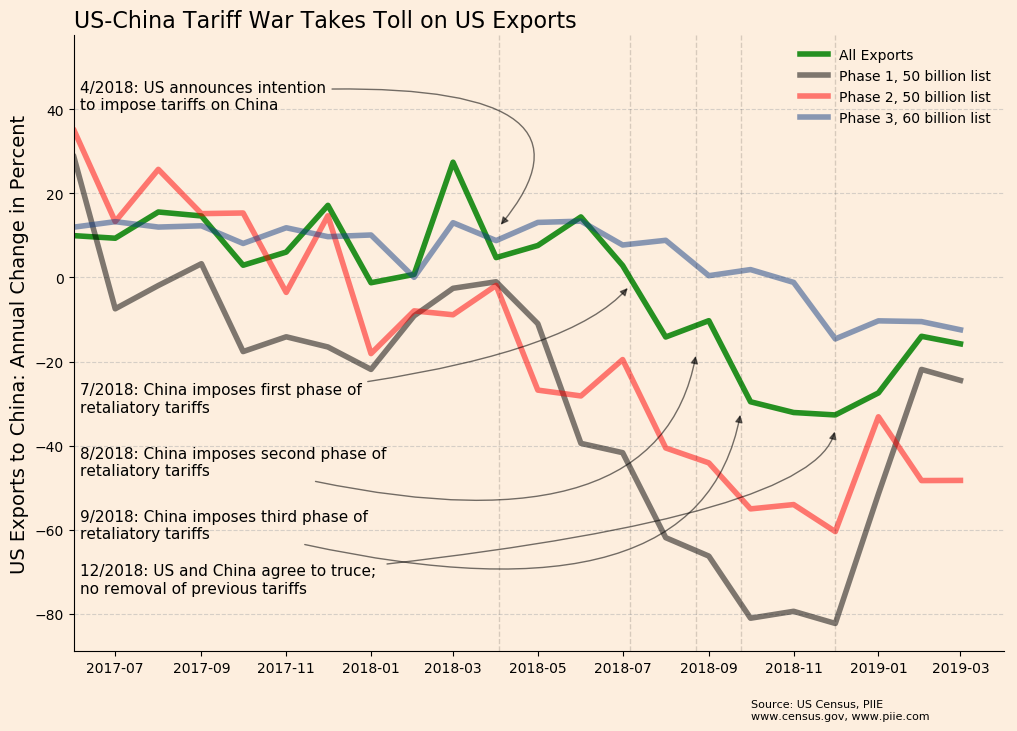

In [182]:
fig, ax = plt.subplots(figsize = (12,8))

background = tuple(np.array([253, 238, 222]) / 255)

mike_blue = tuple(np.array([20, 64, 134]) / 255)
### This is the FT background collor

fig.set_facecolor(background)
ax.set_facecolor(background)

plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

######################################################################################
# Basic fig, ax plotting

ax.plot(aggregate_val.index, 100*aggregate_val.pct_change(12), linewidth = 4, ls = "-", color = 'g', alpha =0.85,
       label = 'All Exports')

ax.plot(fifty_fp.index, 100*fifty_fp.pct_change(12), linewidth = 4, ls = "-", color = 'k', alpha =0.5,
       label = 'Phase 1, 50 billion list')

ax.plot(fifty_sp.index, 100*fifty_sp.pct_change(12), linewidth = 4, ls = "-", color = 'r', alpha =0.5,
       label = 'Phase 2, 50 billion list')

ax.plot(sixty.index, 100*sixty.pct_change(12), linewidth = 4, ls = "-", color = mike_blue, alpha =0.5,
       label = 'Phase 3, 60 billion list')

######################################################################################
# Add some vertical lines to illustrate key events

#ax.axhline(100*np.log(df.ALL_VAL_MO.loc["CHINA"]).diff(12).mean(), linewidth = 4, ls = "--", color = 'k', alpha =0.5)

ax.axvline(dt.datetime(2018,4,3), linewidth = 1, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 1, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 1, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,9,24), linewidth = 1, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 1, ls = "--", color = 'k', alpha =0.15)

ax.set_xlim(dt.datetime(2017,6,1),dt.datetime(2019,4,1))

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.text(dt.datetime(2018,10,1),-105, "Source: US Census, PIIE \n" 
        "www.census.gov, www.piie.com", fontsize = 8)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

###################################################################################
# Add annotation to explain those events.

ax.annotate(
    "4/2018: US announces intention\nto impose tariffs on China", 
    xy=(dt.datetime(2018,4,3), 12), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,6,6), 40), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)


###################################################################################
ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), -2), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,6,6), -32), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8/2018: China imposes second phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), -18), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,6,6), -47), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "9/2018: China imposes third phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), -32), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,6,6), -62), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "12/2018: US and China agree to truce; \nno removal of previous tariffs", 
    xy=(dt.datetime(2018,12,1), -36), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,6,6), -75), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################
# finish up...

ax.legend(loc = 1, frameon  = False)

ax.set_ylabel("US Exports to China: Annual Change in Percent", fontsize = 14)

ax.set_title("US-China Tariff War Takes Toll on US Exports", fontsize = 16, loc= "left" )

###################################################################################

plt.savefig("us_china_trade_war_v2.pdf", bbox_inches = "tight", dip = 3600, facecolor=background)

plt.show()